# Imports

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore')

# formatting options
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 150)
sns.set_theme(style="ticks", palette="muted", font_scale=1.1, context='notebook', rc={'font.size': 12})
plt.rcParams['figure.figsize'] = [4, 3]
%matplotlib inline

# Load csvs

In [78]:
# The csvs created using make_csvs.ipynb could be minorly different based on OS & software versions, therefore loading my csvs for reproducibility
data_humans = pd.read_csv("../csvs/data_humans.csv")
data_LLMs = pd.read_csv("../csvs/data_LLMs.csv")

num_resp = 18

# Analysis

## 1. Participant Clustering: Number of cumulative jumps profile
## Result Sections: Participant Clusters, LLM Assignments

In [79]:
data_humans_clustering = data_humans.groupby(["pid", "task"]).filter(lambda x: len(x) >= num_resp)      # only consider responses with atleast num_resp responses
data_humans_clustering = data_humans_clustering[data_humans_clustering["order"] <= num_resp]            # only consider exactly num_resp responses

data_LLMs_clustering = data_LLMs.groupby(["pid", "task"]).filter(lambda x: len(x) >= num_resp)          # only consider responses with atleast num_resp responses
data_LLMs_clustering = data_LLMs_clustering[data_LLMs_clustering["order"] <= num_resp]                  # only consider exactly num_resp responses
data_LLMs_clustering = data_LLMs_clustering[~((data_LLMs_clustering["task"] == 1) & (data_LLMs_clustering["model"].isin(["NousResearch/Nous-Hermes-2-Mistral-7B-DPO", "palm/text-bison@002"])))]    # remove NousResearch and Palm for VF as they only output animals in alphabetical order

Task = 2
number of participants clustered = 97
%s of participants clustered into each group = [19.587628865979383, 25.773195876288657, 54.63917525773196]
Task = 3
number of participants clustered = 103
%s of participants clustered into each group = [22.330097087378643, 40.77669902912621, 36.89320388349515]
Task = 1
number of participants clustered = 195
%s of participants clustered into each group = [38.46153846153847, 18.974358974358974, 42.56410256410256]


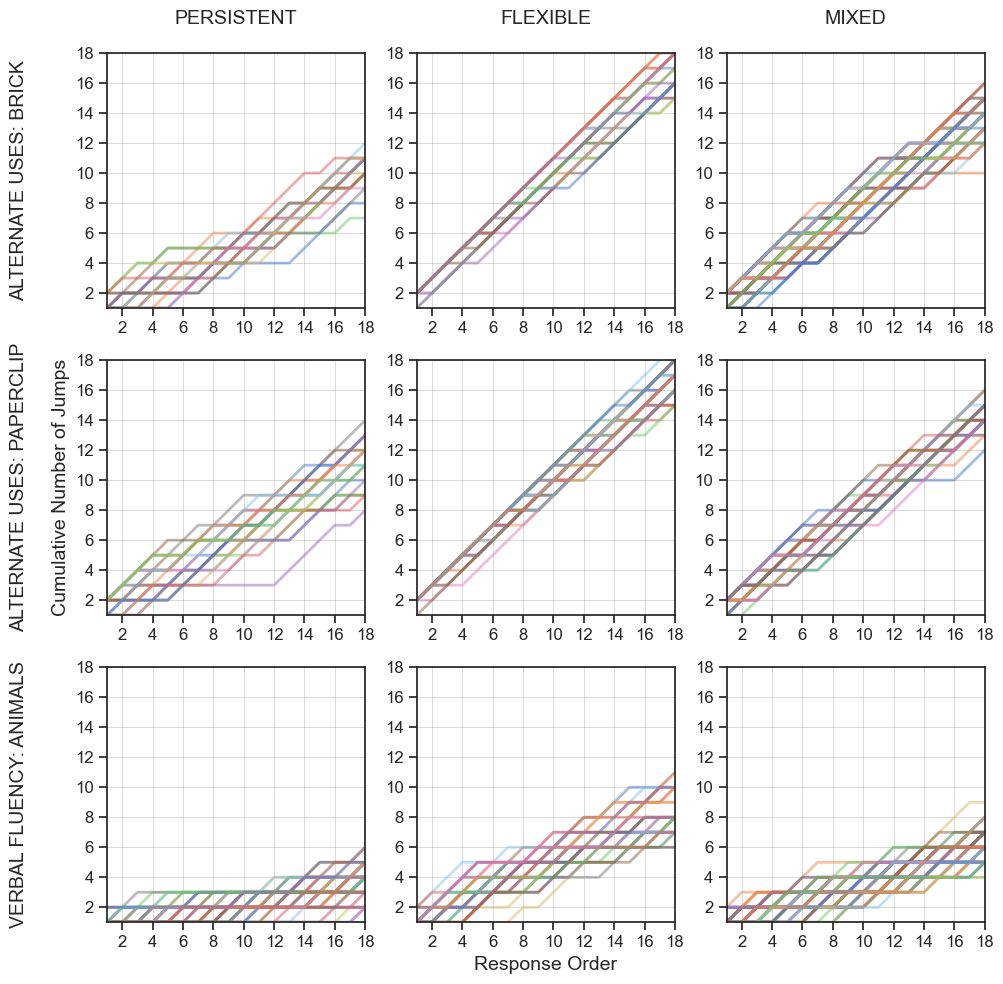

In [80]:
def perform_KMeans(embeddings, num_clusters):
    """Perform KMeans
    Args:
        embeddings (list): List of embeddings
        num_clusters: Number of clusters
    Returns:
        KMeans object
    """
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
    kmeans.fit(embeddings)
    return kmeans

def participant_clustering_cumjumps(data, data_test):       # Cluster human data, assign LLM data
    num_clusters = 3
    _, ax = plt.subplots(3, num_clusters, figsize=(10.2, 10))
    task_to_index = {2:0, 3:1, 1:2}

    for task in [2, 3, 1]:
        pid_to_cumulative_jumps_profile = data[data["task"] == task].groupby("pid").agg(list)["jump_profile"].to_dict()
        data_to_cluster = np.array(list(pid_to_cumulative_jumps_profile.values()))
        pid_to_cumulative_jumps_profile_test = data_test[data_test["task"] == task].groupby("pid").agg(list)["jump_profile"].to_dict()
        data_to_cluster_test = np.array(list(pid_to_cumulative_jumps_profile_test.values()))
        
        kmeans = perform_KMeans(data_to_cluster, num_clusters)
        labels = kmeans.labels_
        predictions = kmeans.predict(data_to_cluster_test)

        # For visualisation purposes:
        cl1meanjumps = sum(data_to_cluster[labels == 0, -1])/len(data_to_cluster[labels == 0, -1])
        cl2meanjumps = sum(data_to_cluster[labels == 1, -1])/len(data_to_cluster[labels == 1, -1])
        cl3meanjumps = sum(data_to_cluster[labels == 2, -1])/len(data_to_cluster[labels == 2, -1])
        sortedjumps = np.argsort([cl1meanjumps, cl2meanjumps, cl3meanjumps])
        d = {0:sortedjumps[0], 1:sortedjumps[2], 2:sortedjumps[1]}
        d_ = {v: k for k, v in d.items()}  

        print("Task =", task)
        print("number of participants clustered =", len(labels))
        print("%s of participants clustered into each group =", [sum(labels == d[0]) / len(labels) * 100, sum(labels == d[1]) / len(labels) * 100, sum(labels == d[2]) / len(labels) * 100])
        
        cluster_names = {0:"PERSISTENT\n", 1: "FLEXIBLE\n", 2: "MIXED\n"}

        # Plotting
        for i in range(num_clusters):
            indices = np.where(labels == d[i])[0]
            for seq in data_to_cluster[indices]:
                ax[task_to_index[task], i].plot(seq, linewidth=2, alpha=0.5)
            ax[task_to_index[task], i].grid(linewidth=0.5)
            ax[task_to_index[task], i].set_xlim(0,num_resp - 1)
            ax[task_to_index[task], i].set_xticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
            ax[task_to_index[task], i].set_ylim(0,num_resp - 1)
            ax[task_to_index[task], i].set_yticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
            if task == 2:
                ax[task_to_index[task], i].set_title(cluster_names[i], fontsize=14)
            if i == 1 and task == 1:
                ax[task_to_index[task], i].set_xlabel("Response Order", fontsize=14)
            if i == 0 and task == 2:
                ax[task_to_index[task], i].set_ylabel("ALTERNATE USES: BRICK\n\n", fontsize=14)
            if i == 0 and task == 3:
                ax[task_to_index[task], i].set_ylabel("ALTERNATE USES: PAPERCLIP\n\nCumulative Number of Jumps", fontsize=14)
            if i == 0 and task == 1:
                ax[task_to_index[task], i].set_ylabel("VERBAL FLUENCY: ANIMALS\n\n", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.2)

        data.loc[data["task"] == task, "participant_cluster"] = data[data["task"] == task]["pid"].map(dict(zip(np.array(list(pid_to_cumulative_jumps_profile.keys())), [d_[l] for l in labels])))
        data_test.loc[data_test["task"] == task, "participant_cluster"] = data_test[data_test["task"] == task]["pid"].map(dict(zip(np.array(list(pid_to_cumulative_jumps_profile_test.keys())), [d_[l] for l in predictions])))

    plt.show()

    return data, data_test

data_humans_clustering, data_LLMs_clustering = participant_clustering_cumjumps(data_humans_clustering, data_LLMs_clustering)

### LLM assignments

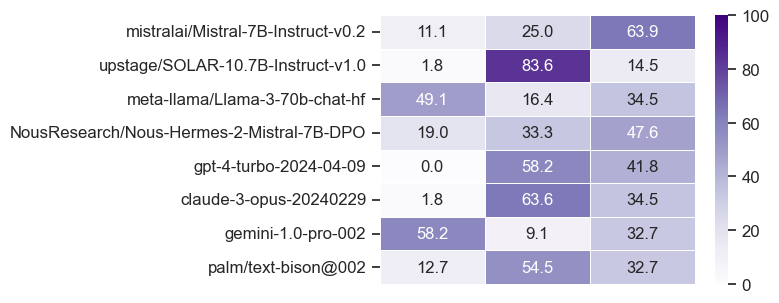

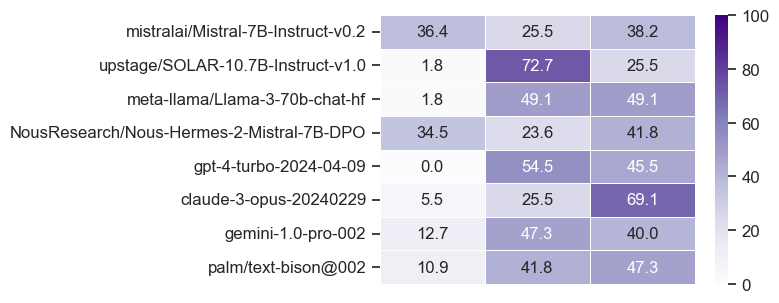

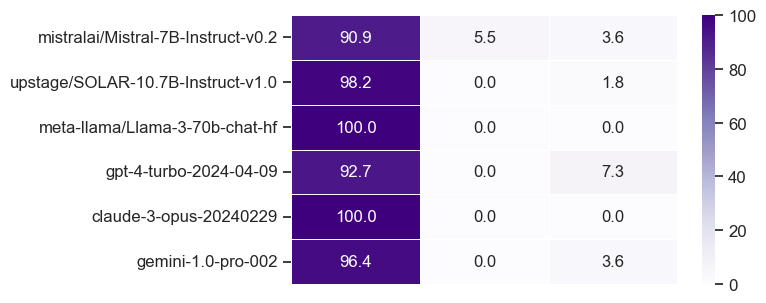

In [81]:
def get_llm_assignments(data):
    group_counts_task2 = data[data["task"] == 2].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]
    group_counts_task3 = data[data["task"] == 3].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]
    group_counts_task1 = data[data["task"] == 1].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]

    model_order_task2 = ["mistralai/Mistral-7B-Instruct-v0.2", "upstage/SOLAR-10.7B-Instruct-v1.0", "meta-llama/Llama-3-70b-chat-hf", "NousResearch/Nous-Hermes-2-Mistral-7B-DPO", \
                "gpt-4-turbo-2024-04-09", "claude-3-opus-20240229", "gemini-1.0-pro-002", "palm/text-bison@002"]
    model_order_task3 = model_order_task2
    model_order_task1 = ["mistralai/Mistral-7B-Instruct-v0.2", "upstage/SOLAR-10.7B-Instruct-v1.0", "meta-llama/Llama-3-70b-chat-hf", \
                "gpt-4-turbo-2024-04-09", "claude-3-opus-20240229", "gemini-1.0-pro-002"]

    group_counts_task2 = group_counts_task2.reindex(pd.MultiIndex.from_product([model_order_task2, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    group_counts_task3 = group_counts_task3.reindex(pd.MultiIndex.from_product([model_order_task3, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    group_counts_task1 = group_counts_task1.reindex(pd.MultiIndex.from_product([model_order_task1, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    for_heatmap_task2 = (100 * group_counts_task2 / group_counts_task2.groupby(level=0).sum()).reset_index()
    for_heatmap_task3 = (100 * group_counts_task3 / group_counts_task3.groupby(level=0).sum()).reset_index()
    for_heatmap_task1 = (100 * group_counts_task1 / group_counts_task1.groupby(level=0).sum()).reset_index()

    # Plotting
    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task2.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task3.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task1.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

get_llm_assignments(data_LLMs_clustering)       # create LLM assignment heatmaps

### Humans vs Models num_jumps

In [82]:
def find_num_jumps(data):
    num_jumps = data.groupby("pid").tail(1)["jump_profile"]
    return num_jumps

def humans_vs_models_numjumps(data_humans, data_LLMs):
    humans_num_jumps_task2, humans_num_jumps_task3, humans_num_jumps_task1 = [find_num_jumps(data_humans[data_humans["task"] == 2]), find_num_jumps(data_humans[data_humans["task"] == 3]), find_num_jumps(data_humans[data_humans["task"] == 1])]
    LLMs_num_jumps_task2, LLMs_num_jumps_task3, LLMs_num_jumps_task1 = [find_num_jumps(data_LLMs[(data_LLMs["task"] == 2)]), find_num_jumps(data_LLMs[data_LLMs["task"] == 3]), find_num_jumps(data_LLMs[data_LLMs["task"] == 1])]

    print("Task 2 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task2, LLMs_num_jumps_task2))
    print("Task 3 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task3, LLMs_num_jumps_task3))
    print("Task 1 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task1, LLMs_num_jumps_task1))

humans_vs_models_numjumps(data_humans_clustering, data_LLMs_clustering)

Task 2 num_jumps humans vs LLMs: Ttest_indResult(statistic=-0.8460089801847719, pvalue=0.397967531947087)
Task 3 num_jumps humans vs LLMs: Ttest_indResult(statistic=-0.5631034159950725, pvalue=0.5735977568639479)
Task 1 num_jumps humans vs LLMs: Ttest_indResult(statistic=20.586859113844074, pvalue=2.043705421163027e-69)


In [83]:
def percent_jumps(data):
    print("AUT Brick Percentage Jumps =", sum(data[data["task"] == 2]["jump"]) / len(data[data["task"] == 2]["jump"]) * 100)
    print("AUT Paperclip Percentage Jumps =", sum(data[data["task"] == 3]["jump"]) / len(data[data["task"] == 3]["jump"]) * 100)
    print("Verbal Fluency Percentage Jumps =", sum(data[data["task"] == 1]["jump"]) / len(data[data["task"] == 1]["jump"]) * 100)

percent_jumps(data_humans)
percent_jumps(data_LLMs)

AUT Brick Percentage Jumps = 74.4478527607362
AUT Paperclip Percentage Jumps = 77.06006640507094
Verbal Fluency Percentage Jumps = 25.99949710837314
AUT Brick Percentage Jumps = 73.64190328017632
AUT Paperclip Percentage Jumps = 76.57799274486095
Verbal Fluency Percentage Jumps = 14.962234744035488


### Temperature Analysis

In [84]:
data_LLMs_temp = data_LLMs_clustering.groupby(["task", "pid"]).tail(1)
data_LLMs_temp['task'] = data_LLMs_temp['task'].astype('category')

#### Temperature ~ cluster

In [85]:
title = 'participant_cluster ~ temp * task'
model = smf.glm(formula='participant_cluster ~ temp * task', data=data_LLMs_temp[data_LLMs_temp["participant_cluster"].isin([0,1])][["temp", "task", "participant_cluster"]], family=sm.families.Binomial()).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

participant_cluster ~ temp * task 
          Variable  Coefficient   p-value
0       Intercept   -10.146688  0.009288
1       task[T.2]    10.941610  0.005124
2       task[T.3]    11.455735  0.003402
3            temp     7.308877  0.088901
4  temp:task[T.2]    -7.253482  0.092968
5  temp:task[T.3]    -7.548189  0.080791


#### Temperature ~ number of jumps

In [86]:
title = 'jump_profile ~ temp, for task 2'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 2][["temp", "task", "jump_profile"]]).fit()  # same even using , family=sm.families.Poisson()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 2].groupby("temp").mean()["jump_profile"].tolist()), "\n")

title = 'jump_profile ~ temp, for task 3'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 3][["temp", "task", "jump_profile"]]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 3].groupby("temp").mean()["jump_profile"].tolist()), "\n")

title = 'jump_profile ~ temp, for task 1'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 1][["temp", "task", "jump_profile"]]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 1].groupby("temp").mean()["jump_profile"].tolist()))

jump_profile ~ temp, for task 2 
     Variable  Coefficient   p-value
0  Intercept    12.951659  0.000000
1       temp     0.534047  0.311059
Correlation: PearsonRResult(statistic=0.3416826169073693, pvalue=0.30374714381586243) 

jump_profile ~ temp, for task 3 
     Variable  Coefficient   p-value
0  Intercept    13.568182  0.000000
1       temp     0.431818  0.175088
Correlation: PearsonRResult(statistic=0.41998822653385165, pvalue=0.1984309673346109) 

jump_profile ~ temp, for task 1 
     Variable  Coefficient       p-value
0  Intercept     0.975758  2.435431e-12
1       temp     1.193939  3.930509e-07
Correlation: PearsonRResult(statistic=0.8875134533608426, pvalue=0.00026663115520457123)


### Sanity Check: jump_profile should impact participant_cluster

In [87]:
title = 'participant_cluster ~ jump_profile + task'
model = smf.glm(formula='participant_cluster ~ jump_profile + task', data=data_LLMs_temp[data_LLMs_temp["participant_cluster"].isin([0,1])][["jump_profile", "task", "participant_cluster"]], family=sm.families.Binomial()).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

participant_cluster ~ jump_profile + task 
        Variable  Coefficient   p-value
0     Intercept   -24.415262  0.000068
1     task[T.2]   -31.464528  0.000457
2     task[T.3]   -34.488923  0.000193
3  jump_profile     4.656762  0.000124


## 2. Jump Signal Reliability and Validity
## Result Sections: Jump Signal Reliability and Validity

### Consistency Across AUT Tasks

In [88]:
data_humans_across_tasks = data_humans.groupby('pid').filter(lambda x: all(
        x[x['task'] == task].shape[0] >= num_resp for task in [2, 3]
    ))  # only keep pids with atleast num_resp responses in EACH AUT task

data_LLMs_across_tasks = data_LLMs.groupby('pid').filter(lambda x: all(
        x[x['task'] == task].shape[0] >= num_resp for task in [2, 3]
    ))  # only keep pids with atleast num_resp responses in EACH AUT task

In [89]:
print("For Humans:")
print("AUT Brick length =", len(data_humans_across_tasks[data_humans_across_tasks["task"] == 2].groupby("pid")))
print("AUT Paperclip length =" ,len(data_humans_across_tasks[data_humans_across_tasks["task"] == 3].groupby("pid")))

print("For LLMs:")
print("AUT Brick length =", len(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 2].groupby("pid")))
print("AUT Paperclip length =", len(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 3].groupby("pid")))

For Humans:
AUT Brick length = 81
AUT Paperclip length = 81
For LLMs:
AUT Brick length = 387
AUT Paperclip length = 387


In [90]:
humans_num_jumps_task2, humans_num_jumps_task3, humans_num_jumps_task1 = [find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 2]), find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 3]), find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 1])]
LLMs_num_jumps_task2, LLMs_num_jumps_task3, LLMs_num_jumps_task1 = [find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 2]), find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 3]), find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 1])]

In [91]:
corr = pearsonr(humans_num_jumps_task2, humans_num_jumps_task3)
print("Humans test-restest corr:", corr, corr.confidence_interval())
print("T-test:", ttest_ind(humans_num_jumps_task2, humans_num_jumps_task3), "\n")

corr = pearsonr(LLMs_num_jumps_task2, LLMs_num_jumps_task3)
print("LLMs test-restest corr:", corr, corr.confidence_interval())
print("T-test:", ttest_ind(LLMs_num_jumps_task2, LLMs_num_jumps_task3))

Humans test-restest corr: PearsonRResult(statistic=0.4217335892545924, pvalue=8.811726000640295e-05) ConfidenceInterval(low=0.22401243238914847, high=0.5861108158731388)
T-test: Ttest_indResult(statistic=-1.8400252033905646, pvalue=0.067617347251242) 

LLMs test-restest corr: PearsonRResult(statistic=0.2231166287064817, pvalue=9.379606232903465e-06) ConfidenceInterval(low=0.12623757830043483, high=0.3157799195724082)
T-test: Ttest_indResult(statistic=-3.697156601812993, pvalue=0.00023345699785711215)


### Validity: AUT vs VF jumping

Ttest_indResult(statistic=23.65159321408252, pvalue=4.2182216953925253e-54)
Ttest_indResult(statistic=26.600678041192523, pvalue=1.2795459693304776e-60)
Ttest_indResult(statistic=49.549494640325015, pvalue=7.56553845578359e-242)
Ttest_indResult(statistic=67.89417481309732, pvalue=0.0)


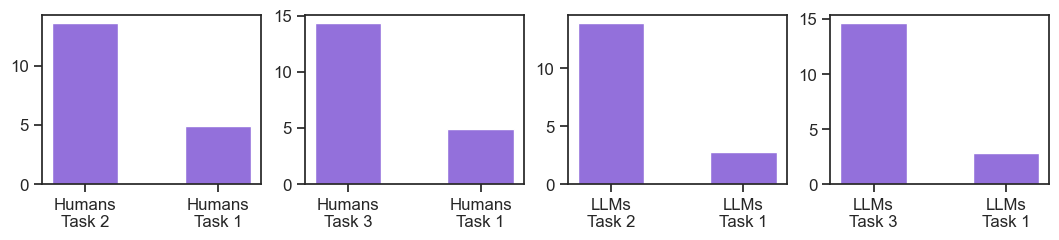

In [92]:
print(ttest_ind(humans_num_jumps_task2, humans_num_jumps_task1))
print(ttest_ind(humans_num_jumps_task3, humans_num_jumps_task1))
fig, ax = plt.subplots(1,4, figsize=(13, 2.2))
ax[0].bar(["Humans\nTask 2", "Humans\nTask 1"], [np.mean(humans_num_jumps_task2), np.mean(humans_num_jumps_task1)], color = "mediumpurple", width=0.5)
ax[1].bar(["Humans\nTask 3", "Humans\nTask 1"], [np.mean(humans_num_jumps_task3), np.mean(humans_num_jumps_task1)], color = "mediumpurple", width=0.5)

print(ttest_ind(LLMs_num_jumps_task2, LLMs_num_jumps_task1))
print(ttest_ind(LLMs_num_jumps_task3, LLMs_num_jumps_task1))
ax[2].bar(["LLMs\nTask 2", "LLMs\nTask 1"], [np.mean(LLMs_num_jumps_task2), np.mean(LLMs_num_jumps_task1)], color = "mediumpurple", width=0.5)
ax[3].bar(["LLMs\nTask 3", "LLMs\nTask 1"], [np.mean(LLMs_num_jumps_task3), np.mean(LLMs_num_jumps_task1)], color = "mediumpurple", width=0.5);

### Validity: Jump ~ RT

Ttest_indResult(statistic=-28.571945717237753, pvalue=5.216941595071701e-173)


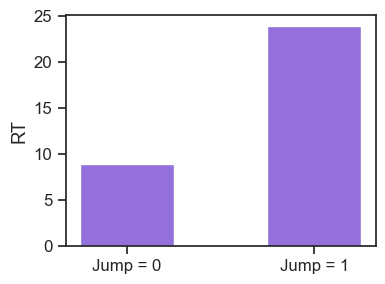

In [93]:
print(ttest_ind(data_humans[data_humans["jump"] == 0]["RT"], data_humans[data_humans["jump"] == 1]["RT"]))
plt.bar(["Jump = 0", "Jump = 1"], [np.mean(data_humans[data_humans["jump"] == 0]["RT"]), np.mean(data_humans[data_humans["jump"] == 1]["RT"])], color = "mediumpurple", width=0.5)
plt.ylabel("RT");

## 3. Originality ~ Cluster
## Result Sections: Relationship to Creativity

In [94]:
data_humans_clustering.loc[(data_humans_clustering["task"].isin([2,3])) & (pd.isnull(data_humans_clustering["originality"])), "originality"] = 2.5      # add in 2 missing originality scores
data_LLMs_clustering.loc[(data_LLMs_clustering["task"].isin([2,3])) & (pd.isnull(data_LLMs_clustering["originality"])), "originality"] = 2

data_humans_originality = data_humans_clustering[data_humans_clustering["task"].isin([2,3])]
data_LLMs_originality = data_LLMs_clustering[data_LLMs_clustering["task"].isin([2,3])]

data_humans_originality["type"] = 0     # type = 0 => humans, tyep = 1 => LLMs
data_LLMs_originality["type"] = 1
data_LLMs_originality['task'] = data_LLMs_originality['task'].astype(int)

data_humans_originality_mean_task2 = data_humans_originality[data_humans_originality["task"] == 2].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_humans_originality_mean_task2["num_jumps"] = data_humans_originality[data_humans_originality["task"] == 2].groupby(["pid"]).tail(1)["jump_profile"].tolist()
data_humans_originality_mean_task3 = data_humans_originality[data_humans_originality["task"] == 3].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_humans_originality_mean_task3["num_jumps"] = data_humans_originality[data_humans_originality["task"] == 3].groupby(["pid"]).tail(1)["jump_profile"].tolist()

data_LLMs_originality_mean_task2 = data_LLMs_originality[data_LLMs_originality["task"] == 2].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_LLMs_originality_mean_task2["num_jumps"] = data_LLMs_originality[data_LLMs_originality["task"] == 2].groupby(["pid"]).tail(1)["jump_profile"].tolist()
data_LLMs_originality_mean_task3 = data_LLMs_originality[data_LLMs_originality["task"] == 3].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_LLMs_originality_mean_task3["num_jumps"] = data_LLMs_originality[data_LLMs_originality["task"] == 3].groupby(["pid"]).tail(1)["jump_profile"].tolist()

data_humans_originality_mean = pd.concat([data_humans_originality_mean_task2, data_humans_originality_mean_task3], axis=0, ignore_index=True)
data_LLMs_originality_mean = pd.concat([data_LLMs_originality_mean_task2, data_LLMs_originality_mean_task3], axis=0, ignore_index=True)

In [95]:
data_humans_originality_mean['task'] = data_humans_originality_mean['task'].astype('category')
data_humans_originality_mean['type'] = data_humans_originality_mean['type'].astype('category')
data_LLMs_originality_mean['task'] = data_LLMs_originality_mean['task'].astype('category')
data_LLMs_originality_mean['type'] = data_LLMs_originality_mean['type'].astype('category')

Ttest_indResult(statistic=-1.107910457580006, pvalue=0.27420506593198984)
Ttest_indResult(statistic=-1.3123577580494925, pvalue=0.19416078247264676)


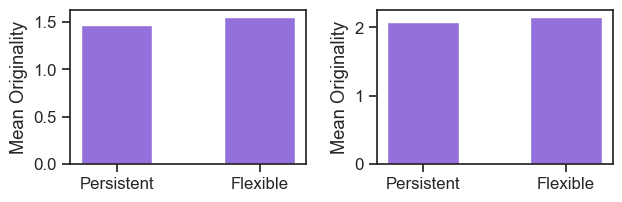

num_jumps ~ originality, for task 2 
       Variable  Coefficient       p-value
0    Intercept     9.718710  8.553563e-09
1  originality     2.130266  5.377417e-02 

num_jumps ~ originality, for task 3 
       Variable  Coefficient   p-value
0    Intercept     8.697303  0.000205
1  originality     2.325803  0.033627


In [96]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
fig.subplots_adjust(wspace=0.3)

# human task2 cluster 0 vs 1
print(ttest_ind(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 2)]["originality"], data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1)  & (data_humans_originality_mean["task"] == 2)]["originality"]))
ax[0].bar(["Persistent", "Flexible"], [np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 2)]["originality"]), np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1) & (data_humans_originality_mean["task"] == 2)]["originality"])], color = "mediumpurple", width=0.5)
ax[0].set_ylabel("Mean Originality");

# human task3 cluster 0 vs 1
print(ttest_ind(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 3)]["originality"], data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1)  & (data_humans_originality_mean["task"] == 3)]["originality"]))
ax[1].bar(["Persistent", "Flexible"], [np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 3)]["originality"]), np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1) & (data_humans_originality_mean["task"] == 3)]["originality"])], color = "mediumpurple", width=0.5)
ax[1].set_ylabel("Mean Originality");

plt.show()

title = 'num_jumps ~ originality, for task 2'
model = smf.glm(formula='num_jumps ~ originality', data=data_humans_originality_mean[data_humans_originality_mean["task"] == 2]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

title = 'num_jumps ~ originality, for task 3'
model = smf.glm(formula='num_jumps ~ originality', data=data_humans_originality_mean[data_humans_originality_mean["task"] == 3]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

Ttest_indResult(statistic=-10.886473060666118, pvalue=8.421561519994597e-23)
Ttest_indResult(statistic=-2.5616574347887773, pvalue=0.011024509263906667)


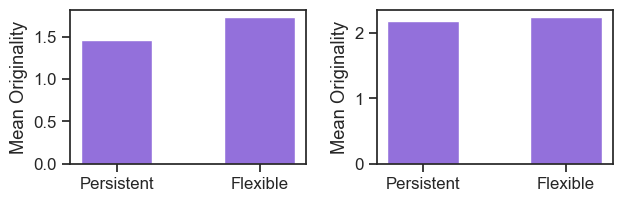

num_jumps ~ originality, for task 2 
       Variable  Coefficient       p-value
0    Intercept     3.873036  6.000817e-04
1  originality     5.667729  5.578652e-17 

num_jumps ~ originality, for task 3 
       Variable  Coefficient       p-value
0    Intercept    10.065874  2.939126e-12
1  originality     1.651105  9.743666e-03 



In [97]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
fig.subplots_adjust(wspace=0.3)

# LLM task2 cluster 0 vs 1
print(ttest_ind(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 2)]["originality"], data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1)  & (data_LLMs_originality_mean["task"] == 2)]["originality"]))
ax[0].bar(["Persistent", "Flexible"], [np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 2)]["originality"]), np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1) & (data_LLMs_originality_mean["task"] == 2)]["originality"])], color = "mediumpurple", width=0.5)
ax[0].set_ylabel("Mean Originality");

# LLM task3 cluster 0 vs 1
print(ttest_ind(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 3)]["originality"], data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1)  & (data_LLMs_originality_mean["task"] == 3)]["originality"]))
ax[1].bar(["Persistent", "Flexible"], [np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 3)]["originality"]), np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1) & (data_LLMs_originality_mean["task"] == 3)]["originality"])], color = "mediumpurple", width=0.5)
ax[1].set_ylabel("Mean Originality");
plt.show()

title = 'num_jumps ~ originality, for task 2'
model = smf.glm(formula='num_jumps ~ originality', data=data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 2]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

title = 'num_jumps ~ originality, for task 3'
model = smf.glm(formula='num_jumps ~ originality', data=data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 3]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

### Type (human or LLM) vs mean originality

In [98]:
print(ttest_ind(data_humans_originality_mean[data_humans_originality_mean["task"] == 2]["originality"], data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 2]["originality"]))
print(ttest_ind(data_humans_originality_mean[data_humans_originality_mean["task"] == 3]["originality"], data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 3]["originality"]))

Ttest_indResult(statistic=-5.495749472699555, pvalue=6.314189618407061e-08)
Ttest_indResult(statistic=-6.622307304220897, pvalue=8.543240133079917e-11)


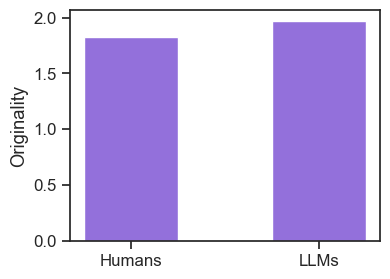

In [99]:
plt.bar(["Humans", "LLMs"], [np.mean(data_humans_originality_mean["originality"]), np.mean(data_LLMs_originality_mean.iloc[np.random.permutation(len(data_LLMs_originality_mean))[:len(data_humans_originality_mean)]]["originality"])], color = "mediumpurple", width=0.5)
plt.ylabel("Originality");
plt.show()